# Shizhong's original code without modifications*

`* Except...
Here's a block of code we had to add
  ```
    if(!is.data.frame(fit)){
        if(fit == "err"){
            next
        }
    }

    if(nrow(fit) == 0) next
  ```
Instead of just
  ```
      if(fit == "err") next`
  ```

Also, in version c, we replace `elastic.net` with version that works for both `1se` and `min`. We use `1se` in version c and `min` in version d

In [1]:
#new lines
load("p1.rda")

In [2]:
library("glmnet")
library("e1071")
library("doParallel")
source("model.R")

args = commandArgs(trailingOnly=TRUE)

set.seed(2018)
wind <- c(5000,10000)
# output directory
#outd <- "/dcl02/lieber/shan/shizhong/finemapping/GWAS/tags/scz3/mwas/chr22/1/"
outd <- "27-OUT/"

# load data for mwas
# load("./rda/caudate_mwas_data_chr22.rda")
#load(as.character(args[2]))
load("BSsample.rda")

# candidate cg
cg <- as.numeric(rownames(p))

Loading required package: Matrix

Loaded glmnet 4.1-8

Loading required package: foreach

Loading required package: iterators

Loading required package: parallel



In [3]:
# modified to use lambda 1se and appropriate cvm
elastic.net <- function(trainX,trainY, lambda.choice = "min"){
    if(nrow(trainX)!=length(trainY)){
            stop("Number of observations is differerent")
    } 

    # optimize alpha---mixing parameter  
    a <- 0.5
    search <- foreach(ai = a, .combine = rbind) %dopar% {
        #set.seed(42)
        cv.fit <- cv.glmnet(
                        trainX,
                        trainY,
                        nfold = 5,
                        type.measure = "mse",
                        parallel = TRUE,
                        alpha = ai
                        )
        #print(paste0("Dim of trainX: ", dim(trainX)))
        #print(paste0("Len of trainY: ", length(trainY)))
        coef_matrix <- as.matrix(coef(cv.fit))

        if(lambda.choice == "1se"){
            chosen_lambda <- cv.fit$lambda.1se
            chosen_cvm <- cv.fit$cvm[cv.fit$lambda == cv.fit$lambda.1se]
        }
        if(lambda.choice == "min"){
            chosen_lambda <- cv.fit$lambda.min
            chosen_cvm <- min(cv.fit$cvm)
        }


        data.frame(
                        cvm = chosen_cvm,
                        lambda = chosen_lambda,
                        alpha = ai
                        )
        } 
    cv.opt <- search[search$cvm == min(search$cvm),] 

        # fit model by optimized alpha and lambda
    #set.seed(42)
    yfit <- glmnet(
    trainX,
    trainY,
    lambda = cv.opt$lambda,
    alpha = cv.opt$alpha)

    idf <- coef(yfit)
    idx <- which(idf != 0)
    selectf <- data.frame(
            features = idf@Dimnames[[1]][idx], 
            coefs = idf [idx]
    )
}

In [4]:
# regress out covariates
load("covs_for_meqtl.rda")
mat <- match(BSsample$brnum,colnames(covs)) 
covs <- t(covs[,mat])
p.residual=matrix(0,dim(p)[1],dim(p)[2])
for(i in 1:dim(p)[1]){
	dat <- as.data.frame(cbind(p[i,],covs))
	colnames(dat) <- c("y",paste0("x",1:33))
	model.res <- lm(reformulate(paste0("x",1:33), "y"),dat)
	p.residual[i,] = resid(model.res) 
}

In [5]:
# built predition models
idx.ea <- BSsample$race == "CAUC"
for(k in 1:length(wind)){
models.ea <- c()
models.all <- c()
for(i in 1:length(cg)){
	#cat(i,"\n")
	range1 <- ifelse(cg[i] - wind[k] > 0,cg[i] - wind[k],0)
	range2 <- cg[i] + wind[k]
	idx <- map2$POS > range1 & map2$POS < range2
	# go to next cg if no snps within window
	if(sum(idx) <= 1){
		next
	}
	geno <- snp2[idx,]
	rownames(geno) <- map2$POS[idx]
	trainX <- t(geno)
	trainY <- p.residual[i,]
	fit <- tryCatch(
		elastic.net(trainX,trainY),
		error = function(e) {return ("err")})

    # Here's a block of code we had to add
    if(!is.data.frame(fit)){
        if(fit == "err"){
            next
        }
    }

    if(nrow(fit) == 0) next
    
	fit$cg <- cg[i]	
	models.all <- rbind(models.all,fit)
	# EA only
	trainX <- trainX[idx.ea,]
	if(sum(apply(trainX,2,var)!=0) <= 1){
		next
	}
	trainY <- trainY[idx.ea]	
	fit <- tryCatch(
		elastic.net(trainX,trainY),
		error = function(e) {return ("err")})
    
    if(!is.data.frame(fit)){
        if(fit == "err"){
            next
        }
    }

    if(nrow(fit) == 0) next
    
	fit$cg <- cg[i]
	models.ea <- rbind(models.ea,fit)
}
models.ea <- models.ea[models.ea[,1] != "(Intercept)",]
models.all <- models.all[models.all[,1] != "(Intercept)",]

# mwas by models of all samples
cg2 <- unique(models.all$cg)
mwas.all <- matrix(0,nrow=length(cg2),ncol=2)
for(i in 1:length(cg2)){
	pos <- models.all[models.all$cg == cg2[i],1]
	gwas <- snp.gwas2$z[is.element(snp.gwas2$pos_hg38, pos)]
	weight <- models.all[models.all$cg == cg2[i],2]
	geno <- snp.1kg.eur2[match(pos,map.1kg.eur2$POS),]
	mwas.all[i,] <- MWAS(gwas, weight, t(geno))
}
rownames(mwas.all) <- cg2
colnames(mwas.all) <- c("z","p")

# mwas by models of EA samples
cg2 <- unique(models.ea$cg)
mwas.ea <- matrix(0,nrow=length(cg2),ncol=2)
for(i in 1:length(cg2)){
	pos <- models.ea[models.ea$cg == cg2[i],1]
	gwas <- snp.gwas2$z[is.element(snp.gwas2$pos_hg38, pos)]
	weight <- models.ea[models.ea$cg == cg2[i],2]
	geno <- snp.1kg.eur2[match(pos,map.1kg.eur2$POS),]
	mwas.ea[i,] <- MWAS(gwas, weight, t(geno))
}
rownames(mwas.ea) <- cg2
colnames(mwas.ea) <- c("z","p")

# output models and mwas results
outf <- paste0(outd,"/models.all.wind.a27b.",wind[k])
write.csv(models.all,outf)
outf <- paste0(outd,"/models.ea.wind.a27b.",wind[k])
write.csv(models.ea,outf)
outf <- paste0(outd,"/mwas.all.wind.a27b.",wind[k])
write.csv(mwas.all,outf)
outf <- paste0(outd,"/mwas.ea.wind.a27b.",wind[k])
write.csv(mwas.ea,outf)
}
	

Warning message:
“executing %dopar% sequentially: no parallel backend registered”
Warning message:
“from glmnet C++ code (error code -98); Convergence for 98th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -96); Convergence for 96th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -100); Convergence for 100th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -97); Convergence for 97th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error cod

In [6]:
models.all

,features,coefs,cg
,<chr>,<dbl>,<dbl>
2,1975412,-0.0009539224,1980077
3,1980240,0.0022669765,1980077
4,1981269,-0.0004006646,1980077
5,1981360,0.0037336129,1980077
6,1987813,-0.0002596163,1980077
7,1989028,0.0026318411,1980077
8,1989994,0.0025790793,1980077
10,1975412,-0.0006331186,1980101
11,1980240,0.0023367713,1980101


In [7]:
mwas.all <- as.data.frame(mwas.all)

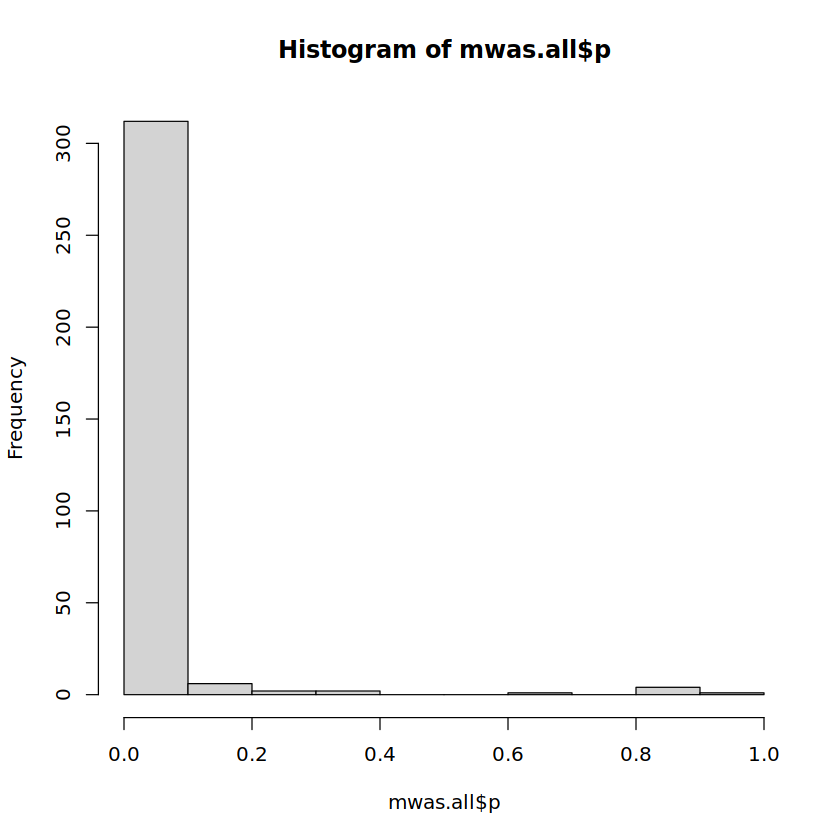

In [8]:
hist(mwas.all$p)

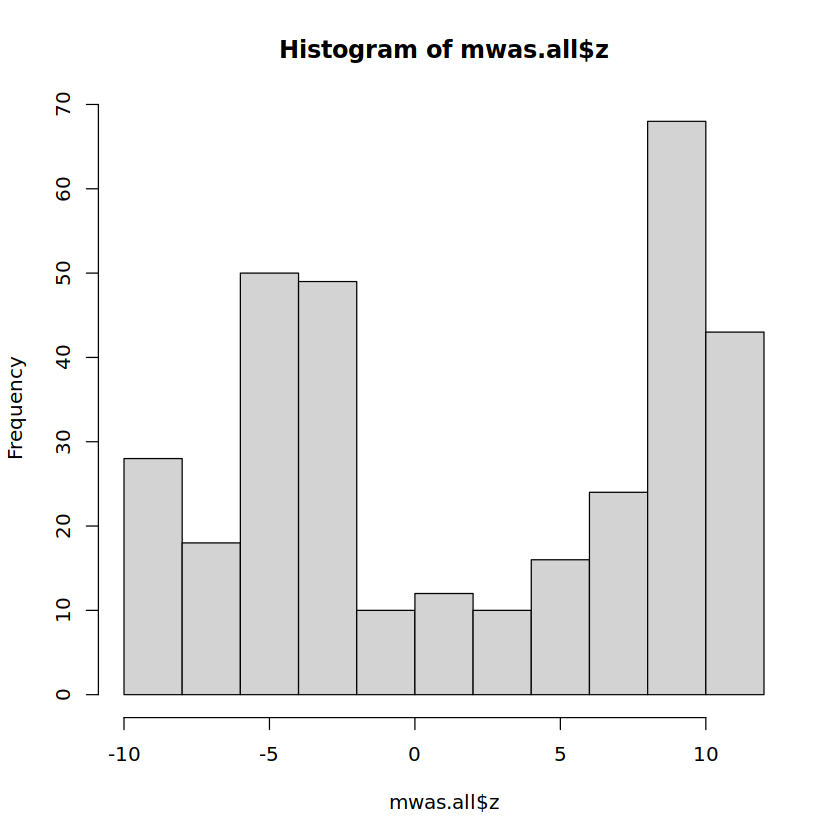

In [9]:
hist(mwas.all$z)

In [10]:
min(mwas.all$p)

[1] 3.386754e-24

In [11]:
mwas.all

,z,p
,<dbl>,<dbl>
1980077,9.943766,2.684799e-23
1980101,9.951569,2.482380e-23
1980129,9.943444,2.693496e-23
1980136,9.955565,2.384651e-23
1980145,9.944063,2.676822e-23
1980179,9.959380,2.294895e-23
1980183,9.964314,2.183766e-23
1980193,9.958000,2.326972e-23
1980205,9.955552,2.384962e-23


In [12]:
getwd()

[1] "/expanse/lustre/projects/jhu152/naglemi/mwas/CpGWAS/scripts"